In [1]:
# !git clone -b update-gluonts https://github.com/time-series-foundation-models/lag-llama/
# !pip install -U -r ./lag-llama/requirements.txt 
# !huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir ./lag-llama
# !pip install gluonts==0.14.4

In [2]:
import os 
import sys

In [3]:
sys.path.append("./time-series-models/lag-llama")
sys.path.append("./lag-llama")

In [4]:
from itertools import islice

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

import yfinance as yf
import numpy as np
from pprint import pprint 
from datetime import date

In [5]:
import sys
from types import ModuleType

# Create dummy module hierarchy
def create_dummy_module(module_path):
    """
    Create a dummy module hierarchy for the given path.
    Returns the leaf module.
    """
    parts = module_path.split('.')
    current = ''
    parent = None

    for part in parts:
        current = current + '.' + part if current else part
        if current not in sys.modules:
            module = ModuleType(current)
            sys.modules[current] = module
            if parent:
                setattr(sys.modules[parent], part, module)
        parent = current

    return sys.modules[module_path]

# Create the dummy gluonts module hierarchy
gluonts_module = create_dummy_module('gluonts.torch.modules.loss')

# Create dummy classes for the specific loss functions
class DistributionLoss:
    def __init__(self, *args, **kwargs):
        pass

    def __call__(self, *args, **kwargs):
        return 0.0

    def __getattr__(self, name):
        return lambda *args, **kwargs: None

class NegativeLogLikelihood:
    def __init__(self, *args, **kwargs):
        pass

    def __call__(self, *args, **kwargs):
        return 0.0

    def __getattr__(self, name):
        return lambda *args, **kwargs: None

# Add the specific classes to the module
gluonts_module.DistributionLoss = DistributionLoss
gluonts_module.NegativeLogLikelihood = NegativeLogLikelihood

In [6]:
def get_lag_llama_predictions(dataset, prediction_length, device, context_length=32, use_rope_scaling=False, num_samples=100):
    # Use this if we have a GPU:
    # ckpt = torch.load("./time-series-models/lag-llama.ckpt", map_location=device) # Uses GPU since in this Colab we use a GPU.
    
    # Assume we use CPU:
    ckpt = torch.load("./lag-llama.ckpt", map_location=device, weights_only=False)
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="./lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

In [7]:
# # ticker = yf.Ticker("AAPL")
# # data_period = "240d"
# # 
# # # Fetch historical market data
# # df = ticker.history(period=data_period)
# # df.head()
# 
# 
# # We need to propagate the item_id column with {Open, High, Low, Close, Volume}
# # Where each item_id will its set of indexed day date, and its associated price
# import requests
# import pandas as pd
# import json
# 
# # replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
# url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=IBM&apikey=demo'
# r = requests.get(url)
# data = r.json()
# 
# 
# # JSON-like dictionary provided by the user
# 
# # Extract the "Time Series (Daily)" section
# time_series = data["Time Series (Daily)"]
# 
# # Convert to DataFrame with the date as the index
# df3 = pd.DataFrame.from_dict(time_series, orient='index')
# 
# # Rename columns for clarity
# df3.rename(columns={
#     "1. open": "open",
#     "2. high": "high",
#     "3. low": "low",
#     "4. close": "close",
#     "5. volume": "volume"
# }, inplace=True)
# 
# # Convert data types to appropriate numerical formats
# df3 = df3.astype({
#     "open": "float",
#     "high": "float",
#     "low": "float",
#     "close": "float",
#     "volume": "int"
# })
# 
# df3 = df3.dropna(subset=['close'])  # Ensure 'close' has no NaNs
# 
# df3.index = pd.to_datetime(df3.index, errors='coerce')
# df3.sort_index(inplace=True)
# 
# df_reset = df3.reset_index().rename(columns={'index': 'date'})
# df_melted = df_reset.melt(id_vars=["date"], var_name="item_id", value_name="target")
# 
# df_melted['date'] = pd.to_datetime(df_melted['date'], errors='coerce')
# df_melted = df_melted.dropna(subset=['date'])
# df_melted.set_index("date", inplace=True)
# 
# df_melted = df_melted[df_melted['item_id'] == 'close']
# 
# df_melted = df_melted[~df_melted.index.duplicated(keep='first')]
# df_melted = df_melted.asfreq('B', method='pad')
# 
# freq = pd.infer_freq(df_melted.index)
# print(f"Frequency inferred: {freq}")
# display(df_melted)
# df_melted.plot()
# plt.show()

In [8]:
# Load dataset
df = pd.read_csv('../AAPL_technical_analysis.csv')

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Drop rows with NaN values
df.dropna(inplace=True)

# Define threshold values
up_threshold = 0.01  # 1% increase
down_threshold = -0.01  # 1% decrease

# Calculate percentage change in close price
df['close_pct_change'] = df['close'].pct_change()

# Create classification function
def classify_direction(pct_change):
    if pd.isna(pct_change):
        return np.nan  # Use NaN instead of None
    elif pct_change >= up_threshold:
        return 0  # Up
    elif pct_change <= down_threshold:
        return 1  # Down
    else:
        return 2  # Hold

# Apply classification function
df['price_direction'] = df['close_pct_change'].apply(classify_direction)

# Drop the first row (since pct_change introduces NaN)
df = df.iloc[1:]

# Drop remaining NaN values
df.dropna(subset=['price_direction'], inplace=True)

# Drop temporary column
df.drop('close_pct_change', axis=1, inplace=True)

# Show first few rows
# print(df[['close', 'price_direction']].head())
display(df)

,open,high,low,close,volume,High-Low,High-Close,Low-Close,True Range,ATR,...,DX,ADX,OBV,RSI,EMA_12,EMA_26,MACD,Signal_Line,MACD_Histogram,price_direction
Date,,,,,,,,,,,,,,,,,,,,,
1999-11-03,81.62,83.25,81.0000,81.50,2932700,2.2500,3.00,0.7500,3.0000,3.367449,...,100.000000,100.000000,4010000,100.000000,78.559290,78.087791,0.471498,0.127868,0.343631,0.0
1999-11-04,82.06,85.37,80.6200,83.62,3384700,4.7500,3.87,0.8800,4.7500,3.466203,...,100.000000,100.000000,7394700,100.000000,79.337861,78.497585,0.840276,0.270349,0.569927,0.0
1999-11-05,84.62,88.37,84.0000,88.31,3721500,4.3700,4.75,0.3800,4.7500,3.557902,...,100.000000,100.000000,11116200,100.000000,80.718190,79.224430,1.493760,0.515031,0.978728,0.0
1999-11-08,87.75,97.73,86.7500,96.37,8490400,10.9800,9.42,1.5600,10.9800,4.088052,...,100.000000,100.000000,19606600,100.000000,83.126161,80.494472,2.631688,0.938363,1.693325,0.0
1999-11-09,94.37,94.50,88.0000,89.62,7224800,6.5000,1.87,8.3700,8.3700,4.393906,...,100.000000,100.000000,12381800,73.529412,84.125213,81.170437,2.954775,1.341645,1.613130,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-14,241.25,245.55,240.9900,244.60,40896227,4.5600,4.02,0.5400,4.5600,6.089485,...,30.536939,18.418021,-2518912928,64.955357,235.511931,235.465421,0.046510,-1.669417,1.715927,0.0
2025-02-18,244.15,245.18,241.8400,244.47,48822491,3.3400,0.58,2.7600,3.3400,5.893093,...,30.536939,19.283658,-2567735419,57.571324,236.890096,236.132427,0.757669,-1.184000,1.941669,2.0
2025-02-19,244.66,246.01,243.1604,244.87,32204215,2.8496,1.54,1.3096,2.8496,5.675701,...,32.085139,20.198050,-2535531204,56.834532,238.117773,236.779655,1.338119,-0.679576,2.017695,2.0


Index(['Date', 'open', 'high', 'low', 'close', 'volume', 'High-Low',
       'High-Close', 'Low-Close', 'True Range', 'ATR', '+DM', '-DM',
       'Smoothed+DM', 'Smoothed-DM', '+DI', '-DI', 'DX', 'ADX', 'OBV', 'RSI',
       'EMA_12', 'EMA_26', 'MACD', 'Signal_Line', 'MACD_Histogram',
       'price_direction'],
      dtype='object')
Frequency inferred: B


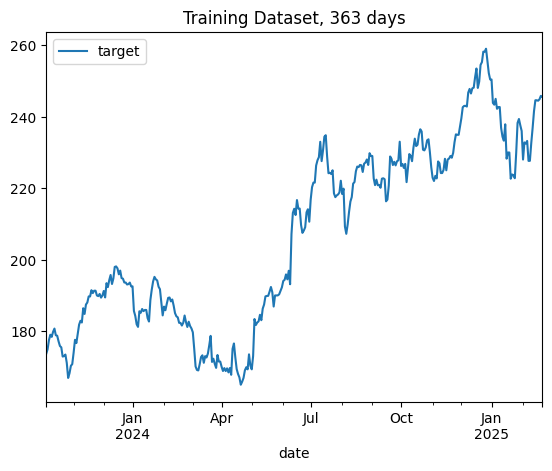

In [9]:
# Convert index to datetime
df.index = pd.to_datetime(df.index)

# Ensure 'close' column has no NaNs
df3 = df.dropna(subset=['close'])

# Ensure index is datetime and sorted
df3.index = pd.to_datetime(df3.index, errors='coerce')
df3.sort_index(inplace=True)

# Reset index and check column names
df_reset = df3.reset_index()
print(df_reset.columns)  # Check actual column names

# Rename the correct column if needed
if 'index' in df_reset.columns:
    df_reset.rename(columns={'index': 'date'}, inplace=True)
elif 'Date' in df_reset.columns:
    df_reset.rename(columns={'Date': 'date'}, inplace=True)  # Some datasets store date as 'Date'

# Melt DataFrame
df_melted = df_reset.melt(id_vars=["date"], var_name="item_id", value_name="target")

# Ensure 'date' is properly formatted
df_melted['date'] = pd.to_datetime(df_melted['date'], errors='coerce')
df_melted = df_melted.dropna(subset=['date'])
df_melted.set_index("date", inplace=True)

# Keep only 'close' prices
df_melted = df_melted[df_melted['item_id'] == 'close']

# Remove duplicate timestamps
df_melted = df_melted[~df_melted.index.duplicated(keep='first')]

# Ensure regular business day frequency
df_melted = df_melted.asfreq('B', method='pad')

# Infer frequency
freq = pd.infer_freq(df_melted.index)
if freq is None:
    freq = "B"
print(f"Frequency inferred: {freq}")

# Cut out 365*16 preceding days
df_melted = df_melted.iloc[int(365*16 + 400):]

# Display & plot
df_melted.plot(title = f"Training Dataset, {len(df_melted)} days")
plt.show()

In [10]:
df_melted

,item_id,target
date,,
2023-10-04,close,173.66
2023-10-05,close,174.91
2023-10-06,close,177.49
2023-10-09,close,178.99
2023-10-10,close,178.39
...,...,...
2025-02-17,close,244.60
2025-02-18,close,244.47
2025-02-19,close,244.87


In [11]:
# set numerical columns as float32
for col in df_melted.columns:
    # Check if column is not of string type
    if df_melted[col].dtype != 'object' and pd.api.types.is_string_dtype(df_melted[col]) == False:
        df_melted[col] = df_melted[col].astype('float32')

# Create the Pandas
dataset = PandasDataset.from_long_dataframe(df_melted, target="target", item_id="item_id")

backtest_dataset = dataset
# prediction_length = 24  # Define your prediction length. We use 24 here since the data is of hourly frequency

prediction_length = 24 # We predict just the next day?

num_samples = 550 # number of samples sampled from the probability distribution for each timestep
# device = torch.device("cuda:0") # You can switch this to CPU or other GPUs if you'd like, depending on your environment

# Lets go CPU
device = torch.device("cpu") 
context_length = 32

In [12]:
ckpt = torch.load("lag-llama.ckpt", map_location=device, weights_only = False)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # distr_output="neg_bin",
        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=5e-4,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        # rope_scaling={
        #     "type": "linear",
        #     "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        # },

        batch_size=32,
        num_parallel_samples=num_samples,
        trainer_kwargs = {"max_epochs": 20,}, # <- lightning trainer arguments
    )

In [13]:
# from gluonts.dataset.repository.datasets import get_dataset
# dataset = get_dataset("m4_weekly")
# print(dataset.train)
predictor = estimator.train(backtest_dataset, cache_data=True, shuffle_buffer_length=1000)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/lajiet/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/lajiet/anaconda3/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:44: Attribute 'loss' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['loss'])`.
/Users/lajiet/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_vali

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 4.91901 (best 4.91901), saving model to '/Users/lajiet/Documents/N_AdvancedPython/APDS-Project/time-series-models/lightning_logs/version_75/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 3.42099 (best 3.42099), saving model to '/Users/lajiet/Documents/N_AdvancedPython/APDS-Project/time-series-models/lightning_logs/version_75/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 3.09431 (best 3.09431), saving model to '/Users/lajiet/Documents/N_AdvancedPython/APDS-Project/time-series-models/lightning_logs/version_75/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 2.95698 (best 2.95698), saving model to '/Users/lajiet/Documents/N_AdvancedPython/APDS-Project/time-series-models/lightning_logs/version_75/checkpoints/epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 3

Forecasting batches:   0%|          | 0/1 [00:00<?, ?it/s]/Users/lajiet/anaconda3/lib/python3.11/site-packages/gluonts/dataset/pandas.py:174: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  df = df.to_period(freq=self.freq)
/Users/lajiet/anaconda3/lib/python3.11/site-packages/gluonts/dataset/split.py:181: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  sliced_entry[FieldName.START] += offset
/Users/lajiet/anaconda3/lib/python3.11/site-packages/gluonts/transform/feature.py:364: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  index = pd.period_range(start, periods=length, freq=start.freq)
/Users/lajiet/anaconda3/lib/python3.11/site-packages/gluonts/transform/feature.py:364: FutureWarning: PeriodDtype[B] is deprecated and will be re

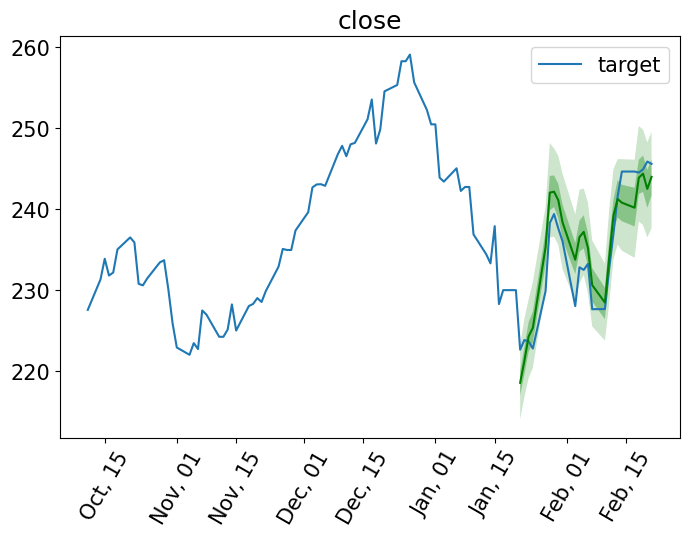

In [14]:
from tqdm import tqdm
forecast_it, ts_it = make_evaluation_predictions(
        dataset=backtest_dataset,
        predictor=predictor,
        num_samples=num_samples
    )
forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))
tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth"))

plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4*prediction_length:].to_timestamp(), label="target", )
    # plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

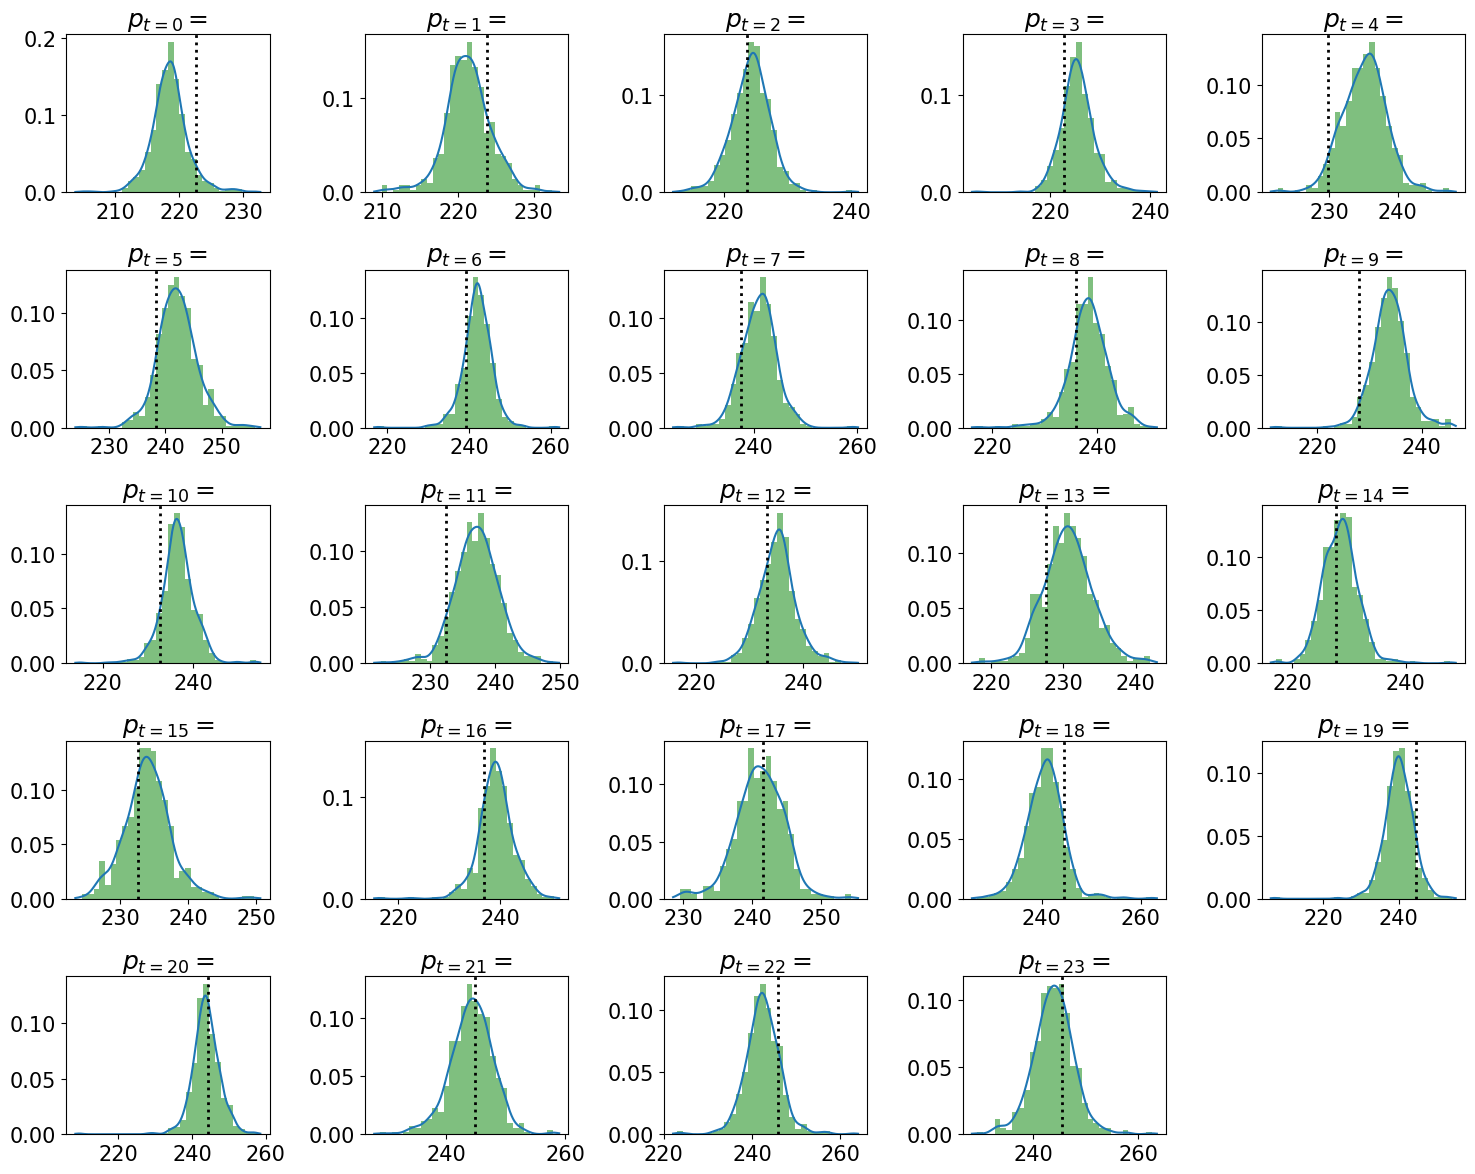

In [15]:
from scipy.stats import gaussian_kde


rows, cols = 5, 5  # Can adjust if needed
fig, axes = plt.subplots(rows, cols, figsize=(15, 12))
axes = axes.flatten()  

kdes = []
# Process each 24 time step 
for t in range(24):  
    ax = axes[t]  

    # Extract samples for time step t across 350 samples
    samples = forecast.samples[:, t]  # Shape: (350,)

    kde_1 = gaussian_kde(samples)
    kdes.append(kde_1)
    x_values = np.linspace(samples.min() - 1, samples.max() + 1, 1000)
    y_values = kde_1(x_values)

    ax.plot(x_values, y_values, label="KDE")
    ax.hist(samples, bins=30, density=True, alpha=0.5, label="histogram", color='green')
    ax.axvline(x=df_melted["target"].iloc[-prediction_length + t], color='black', linestyle='dotted', linewidth=2)
    ax.set_title(r"$p_{t=" + str(t) + r"} = " + r"$")
    # ax.legend()

for i in range(t + 1, len(axes)):  
    fig.delaxes(axes[i])  # Remove unused subplots

plt.tight_layout()
plt.show()

In [16]:
kdes[:2]

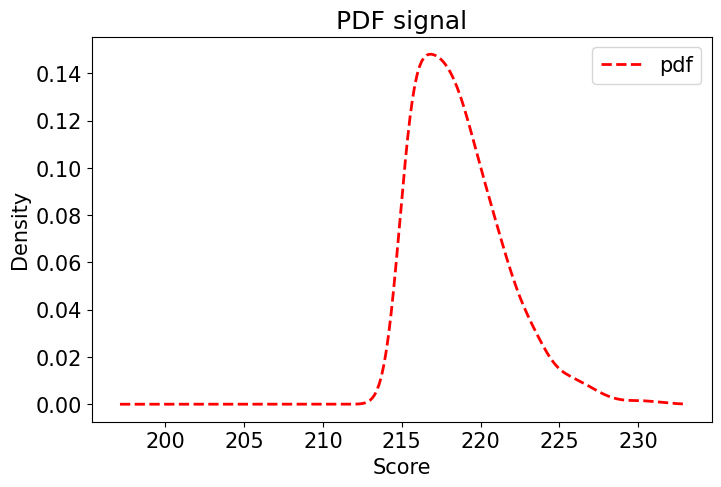

In [17]:

def how_we_feelin_today(center=0, variance=1, skewness=0, num_samples=1000, bw='scott', range_min=None, range_max=None):
    std_dev = np.sqrt(variance)  # convert variance to standard deviation

    # default range if not provided
    if range_min is None:
        range_min = center - 4 * std_dev  # 4-sigma rule for coverage
    if range_max is None:
        range_max = center + 4 * std_dev

    # base samples from a normal distribution
    base_samples = np.random.normal(loc=center, scale=std_dev, size=num_samples)

    # Apply skewness transformation if needed
    if skewness != 0:
        base_samples = stats.skewnorm.rvs(a=skewness * 5, loc=center, scale=std_dev, size=num_samples)

    # keep values within range
    base_samples = np.clip(base_samples, range_min, range_max)

    kde = stats.gaussian_kde(base_samples, bw_method=bw)

    # generate x-range for KDE evaluation
    x_range = np.linspace(range_min, range_max, 240)
    kde_values = kde(x_range)

    return x_range, kde_values, kde

x_range, pdf_values, pdf_func1 = how_we_feelin_today(center=215, variance=20, skewness=5, num_samples=2000, bw=0.3)

plt.figure(figsize=(8, 5))
plt.plot(x_range, pdf_values, color="red", linewidth=2, linestyle="dashed", label="pdf")
plt.xlabel("Score")
plt.ylabel("Density")
plt.title("PDF signal")

plt.legend()
plt.show()

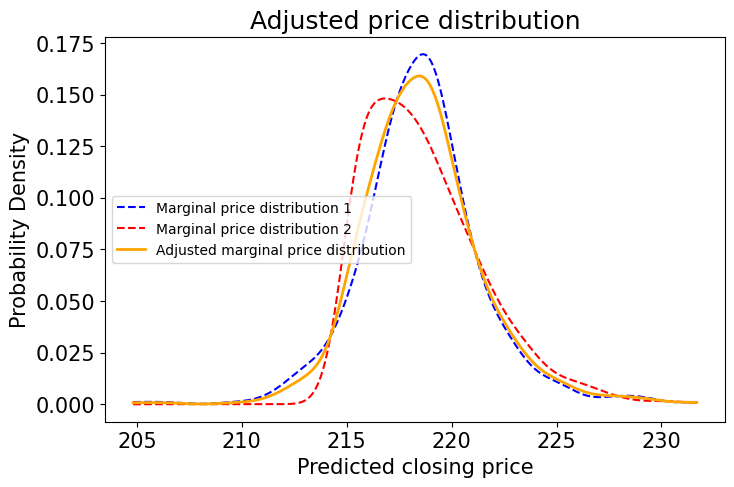

In [18]:
def bma_kde(x_range, kde_1, kde_2, w_1=0.6, w_2=0.4):
    weight_sum = w_1 + w_2
    w_1 /= weight_sum
    w_2 /= weight_sum

    # compute individual KDEs and normalize
    pdf_1 = kde_1(x_range)
    pdf_1 /= np.trapz(pdf_1, x_range)  

    pdf_2 = kde_2(x_range)
    pdf_2 /= np.trapz(pdf_2, x_range)  

    # Compute weighted sum
    bma_pdf = w_1 * pdf_1 + w_2 * pdf_2
    bma_pdf /= np.trapz(bma_pdf, x_range)  # Normalize final BMA kDE
    
    return bma_pdf

x_range = np.linspace(min(min(kdes[0].dataset[0]), min(pdf_func1.dataset[0])),
                      max(max(kdes[0].dataset[0]), max(pdf_func1.dataset[0])),
                      500)

# Compute BMA KDE
bma_pdf_values = bma_kde(x_range, kdes[0], pdf_func1, w_1=0.7, w_2=0.3)

# Plot 
plt.figure(figsize=(8, 5))

plt.plot(x_range, kdes[0](x_range), label="Marginal price distribution 1", linestyle="dashed", color="blue")
plt.plot(x_range, pdf_func1(x_range), label="Marginal price distribution 2", linestyle="dashed", color="red")
plt.plot(x_range, bma_pdf_values, label="Adjusted marginal price distribution", color="orange", linewidth=2)

plt.xlabel("Predicted closing price")
plt.ylabel("Probability Density")
plt.title("Adjusted price distribution")
plt.legend(fontsize=10)
plt.show()

In [ ]:
import random

rows, cols = 5, 5  
fig, axes = plt.subplots(rows, cols, figsize=(15, 12))
axes = axes.flatten()  

kdes = []
cs = []
sks = []
vs = []
# process each 24 time step 
for t in range(24):  
    ax = axes[t]  

    # Extract samples for time step t across 350 samples
    samples = forecast.samples[:, t]  

    kde_1 = gaussian_kde(samples)
    kdes.append(kde_1)
    x_values = np.linspace(samples.min() - 1, samples.max() + 1, 1000)
    y_values = kde_1(x_values)

    x_range = np.linspace(min(min(kde_1.dataset[0]), min(pdf_func1.dataset[0])),
                        max(max(kde_1.dataset[0]), max(pdf_func1.dataset[0])),
                        100)

    c = np.mean(kde_1.dataset[0])
    sk = float(np.random.uniform(-20, 20, 1)) 
    v = float(np.random.uniform(0.1, 20, 1))   # Avoid zero variance & ensure scalar
    cs.append(c)
    sks.append(sk)
    vs.append(v)

    x_range, pdf_values, pdf_func1 = how_we_feelin_today(center=c, variance=v, skewness=sk, num_samples=2000, bw=0.1)

    # Compute BMA KDE
    bma_pdf_values = bma_kde(x_range, kde_1, pdf_func1, w_1=0.6, w_2=0.4)



    ax.plot(x_values, y_values, label="KDE")
    ax.hist(samples, bins=30, density=True, alpha=0.5, label="histogram", color='green')
    ax.axvline(x=df_melted["target"].iloc[-prediction_length + t], color='black', linestyle='dotted', linewidth=2)

    ax.plot(x_range, pdf_func1(x_range), label="KDE 2", linestyle="dashed", color="red")
    ax.plot(x_range, bma_pdf_values, label="BMA KDE", color="orange", linewidth=2)

    ax.set_title(r"$Close_{t=" + str(t) + r"}" + r"$")
    # ax.legend()

for i in range(t + 1, len(axes)):  
    fig.delaxes(axes[i])  # Remove unused subplots

plt.tight_layout()
plt.show()

/var/folders/75/q92ms1g96zg7cy3q5zmjh2100000gn/T/ipykernel_23507/3790153815.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sk = float(np.random.uniform(-20, 20, 1))
/var/folders/75/q92ms1g96zg7cy3q5zmjh2100000gn/T/ipykernel_23507/3790153815.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v = float(np.random.uniform(0.1, 20, 1))   # Avoid zero variance & ensure scalar


Forecasting batches:   0%|          | 0/1 [00:00<?, ?it/s]/Users/lajiet/anaconda3/lib/python3.11/site-packages/gluonts/transform/feature.py:364: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  index = pd.period_range(start, periods=length, freq=start.freq)
/Users/lajiet/anaconda3/lib/python3.11/site-packages/gluonts/transform/feature.py:364: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  index = pd.period_range(start, periods=length, freq=start.freq)
/Users/lajiet/anaconda3/lib/python3.11/site-packages/gluonts/transform/split.py:150: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  entry[self.start_field] + idx + self.lead_time
Ground truth:   0%|          | 0/1 [00:00<?, ?it/s]/Users/lajiet/anaconda3/lib/python3.11/site-packages

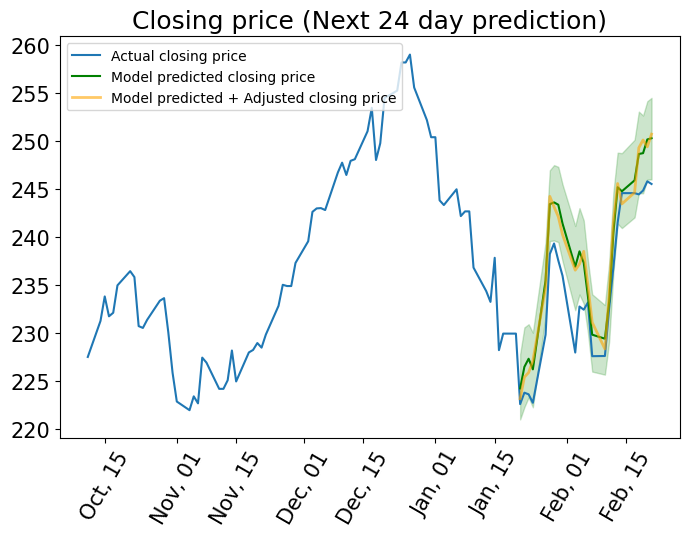

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm
from scipy.stats import gaussian_kde
from itertools import islice

# Function to compute mode of KDE
def kde_mode(kde, x_range):
    return x_range[np.argmax(kde(x_range))]  # Max density point

# Define BMA function to work for arbitrary PDFs (KDE or Gaussian)
def bma_pdf(x_range, pdf_1, pdf_2, w_1=0.6, w_2=0.4):
    """ Compute Bayesian Model Averaging (BMA) of two distributions (KDE or Gaussian). """
    weight_sum = w_1 + w_2
    w_1 /= weight_sum
    w_2 /= weight_sum

    pdf_values_1 = pdf_1(x_range) if callable(pdf_1) else pdf_1  
    pdf_values_2 = pdf_2(x_range) if callable(pdf_2) else pdf_2

    bma_values = w_1 * pdf_values_1 + w_2 * pdf_values_2
    bma_values /= np.trapz(bma_values, x_range)  # Normalize

    return bma_values

# forecasting
forecast_it, ts_it = make_evaluation_predictions(
    dataset=backtest_dataset,
    predictor=predictor,
    num_samples=num_samples
)
forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))
tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth"))

# plot config
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate over the first 9 series and overlay BMA KDE
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    # extract last few target values
    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="Actual closing price", color='#1f77b4')

    # compute kde for forecasted samples at each time step
    bma_estimates = []
    lower_bounds, upper_bounds = [], []

    for t in range(prediction_length):
        # extract forecast samples at time t
        samples = forecast.samples[:, t]  

        # KDE for model 1 
        kde_1 = gaussian_kde(samples)

        x_range, pdf_values, pdf_func2 = how_we_feelin_today(
            center=cs[t], variance=vs[t], skewness=sks[t], num_samples=2000, bw=0.1
        )

        # Compute BMA KDE
        bma_pdf_values = bma_pdf(x_range, kde_1, pdf_func2, w_1=0.6, w_2=0.4)

        # Choose central estimate: mean, median, or mode
        chosen_estimate = "mean"  # Hyperparamter for inference 

        if chosen_estimate == "mean":
            bma_estimate = np.trapz(x_range * bma_pdf_values, x_range)  
        elif chosen_estimate == "median":
            bma_estimate = x_range[np.searchsorted(np.cumsum(bma_pdf_values), 0.5)]
        elif chosen_estimate == "mode":
            bma_estimate = kde_mode(lambda x: bma_pdf(x, kde_1, pdf_func2), x_range)

        bma_estimates.append(bma_estimate)

        # Compute bounds (e.g., 90% credible interval)
        # lower_bound = np.percentile(samples, 5)
        # upper_bound = np.percentile(samples, 95)
        # lower_bounds.append(lower_bound)
        # upper_bounds.append(upper_bound)

    # Overlay BMA estimate on forecast plot
    forecast_dates = pd.period_range(start=forecast.start_date, periods=prediction_length, freq="B").to_timestamp()
    # Overlay raw forecast samples (green) and existing model forecast
    # forecast.plot(color='g')
    plt.plot(forecast_dates, forecast.mean, color='g', label="Model predicted closing price")  # forecast
    plt.fill_between(forecast_dates, forecast.quantile(0.1), forecast.quantile(0.9), color="green", alpha=0.2)  # uncertainty bounds


    plt.plot(forecast_dates, bma_estimates, label="Model predicted + Adjusted closing price", color="orange", linewidth=2, alpha=0.6)
    # plt.fill_between(forecast_dates, lower_bounds, upper_bounds, color="orange", alpha=0.2, label="BMA Uncertainty")




    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title("Closing price (Next 24 day prediction)")

plt.gcf().tight_layout()
plt.legend(fontsize=10)
plt.show()